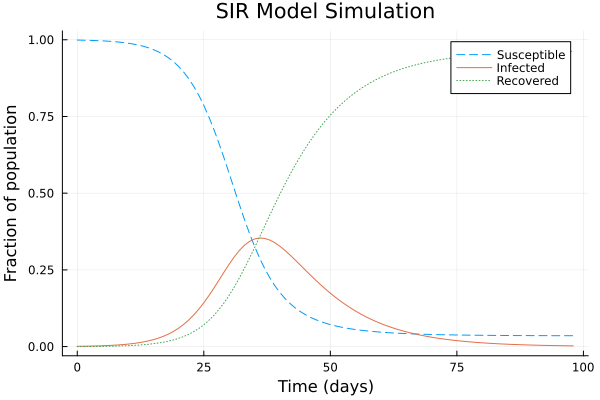

In [1]:
using Plots

# Definiowanie stanu systemu jako krotki
function initial_state()
    s = 999.0
    i = 1.0
    r = 0.0
    total = s + i + r
    s /= total
    i /= total
    r /= total
    return s, i, r
end

# Definiowanie parametrów systemu jako słownik
function make_system()
    tc = 3.0  # czas między kontaktami w dniach
    tr = 10.0  # czas wyzdrowienia w dniach

    beta = 1 / tc  # wskaźnik kontaktów na dzień
    gamma = 1 / tr  # wskaźnik wyzdrowień na dzień

    t_end = 7 * 14  # koniec symulacji w dniach

    return Dict(:beta => beta, :gamma => gamma, :t_end => t_end)
end

# Funkcja aktualizacji stanu
function update_state(s, i, r, system)
    beta = system[:beta]
    gamma = system[:gamma]

    infected = beta * i * s
    recovered = gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return s, i, r
end

# Symulacja modelu SIR
function run_simulation(system, update_func)
    s, i, r = initial_state()
    t_end = system[:t_end]

    S = [s]
    I = [i]
    R = [r]

    for t in 1:t_end
        s, i, r = update_func(s, i, r, system)
        push!(S, s)
        push!(I, i)
        push!(R, r)
    end

    return S, I, R
end

# Funkcja rysująca wyniki symulacji
function plot_results(S, I, R)
    plot(0:length(S)-1, S, label="Susceptible", linestyle=:dash)
    plot!(0:length(I)-1, I, label="Infected")
    plot!(0:length(R)-1, R, label="Recovered", linestyle=:dot)
    xlabel!("Time (days)")
    ylabel!("Fraction of population")
    title!("SIR Model Simulation")
    #grid!(true)
end

# Główna część programu
system = make_system()
S, I, R = run_simulation(system, update_state)
plot_results(S, I, R)


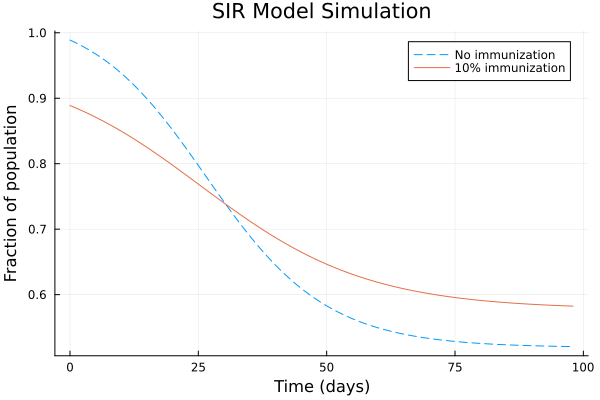

Total infected (no immunization): 0.468320811028781
Total infected (10% immunization): 0.30650802853979753


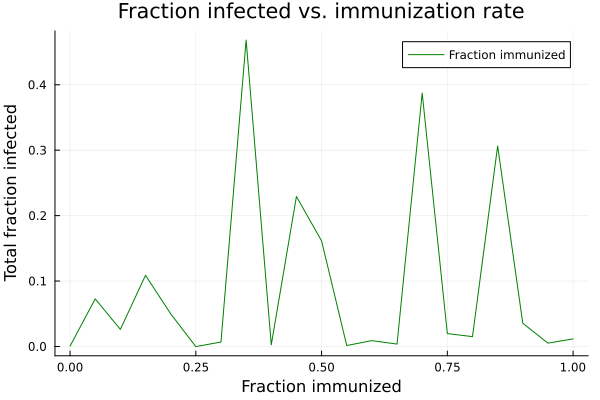

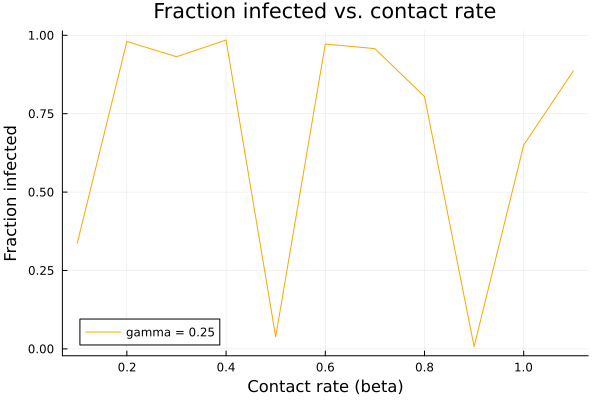

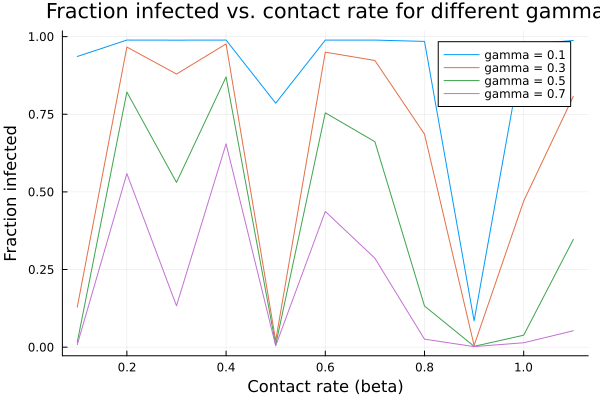

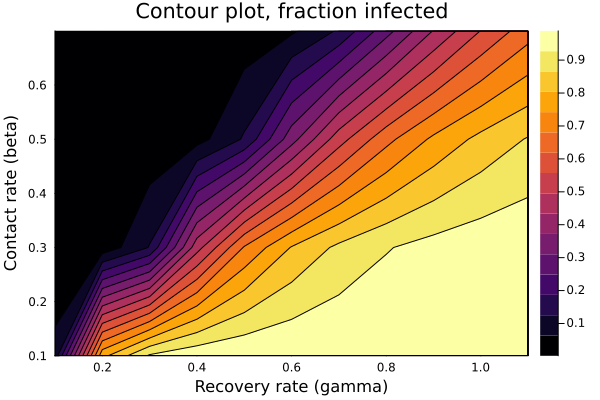

In [6]:
using Plots

# Funkcja do dodania immunizacji
function add_immunization(system, fraction)
    system[:init_s] -= fraction
    system[:init_r] += fraction
end

# Definiowanie funkcji `make_system` i innych podstawowych funkcji z poprzedniego kodu
function initial_state()
    s = 89.0
    i = 1.0
    r = 0.0
    total = s + i + r
    s /= total
    i /= total
    r /= total
    return s, i, r
end

function make_system(beta, gamma)
    s, i, r = initial_state()
    t_end = 7 * 14  # koniec symulacji w dniach
    return Dict(:init_s => s, :init_i => i, :init_r => r, :t_end => t_end, :beta => beta, :gamma => gamma)
end

function update_state(s, i, r, system)
    beta = system[:beta]
    gamma = system[:gamma]

    infected = beta * i * s
    recovered = gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return s, i, r
end

function run_simulation(system, update_func)
    s, i, r = system[:init_s], system[:init_i], system[:init_r]
    t_end = system[:t_end]

    S = [s]
    I = [i]
    R = [r]

    for t in 1:t_end
        s, i, r = update_func(s, i, r, system)
        push!(S, s)
        push!(I, i)
        push!(R, r)
    end

    return S, I, R
end

function plot_results(S, I, R, label)
    p = plot(0:length(S)-1, S, label="Susceptible ($label)", linestyle=:dash)
    plot!(p, 0:length(I)-1, I, label="Infected ($label)")
    plot!(p, 0:length(R)-1, R, label="Recovered ($label)", linestyle=:dot)
    xlabel!("Time (days)")
    ylabel!("Fraction of population")
    title!("SIR Model Simulation")
    display(p)
end

function calc_total_infected(results)
    s_0 = results[1]
    s_end = results[end]
    return s_0 - s_end
end

function sweep_immunity(fraction_array, beta, gamma)
    sweep = Dict()

    for fraction in fraction_array
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        S, I, R = run_simulation(system, update_state)
        sweep[fraction] = calc_total_infected(S)
    end

    return sweep
end

function sweep_beta(beta_array, gamma)
    sweep = Dict()
    for beta in beta_array
        system = make_system(beta, gamma)
        S, I, R = run_simulation(system, update_state)
        sweep[beta] = calc_total_infected(S)
    end
    return sweep
end

function sweep_parameters(beta_array, gamma_array)
    frame = Dict()
    for gamma in gamma_array
        frame[gamma] = sweep_beta(beta_array, gamma)
    end
    return frame
end

function plot_contour(frame, beta_array, gamma_array)
    Z = [frame[gamma][beta] for gamma in gamma_array, beta in beta_array]
    contourf(beta_array, gamma_array, Z)
    xlabel!("Recovery rate (gamma)")
    ylabel!("Contact rate (beta)")
    title!("Contour plot, fraction infected")
end

# Główna część programu
beta = 1 / 3.0
gamma = 1 / 4.0
system = make_system(beta, gamma)
S, I, R = run_simulation(system, update_state)

i = 0.1  # procent zaszczepionej populacji
system2 = make_system(beta, gamma)
add_immunization(system2, i)
S2, I2, R2 = run_simulation(system2, update_state)

p1 = plot(0:length(S)-1, S, label="No immunization", linestyle=:dash)
plot!(p1, 0:length(S2)-1, S2, label="10% immunization")
xlabel!(p1, "Time (days)")
ylabel!(p1, "Fraction of population")
title!(p1, "SIR Model Simulation")
display(p1)

total_infected_no_immunization = calc_total_infected(S)
total_infected_immunization = calc_total_infected(S2)

println("Total infected (no immunization): $total_infected_no_immunization")
println("Total infected (10% immunization): $total_infected_immunization")

fraction_array = range(0, stop=1, length=21)
infected_sweep = sweep_immunity(fraction_array, beta, gamma)

p2 = plot(fraction_array, collect(values(infected_sweep)), label="Fraction immunized", color=:green)
xlabel!(p2, "Fraction immunized")
ylabel!(p2, "Total fraction infected")
title!(p2, "Fraction infected vs. immunization rate")
display(p2)

beta_array = range(0.1, stop=1.1, length=11)
gamma = 0.25
infected_sweep = sweep_beta(beta_array, gamma)

p3 = plot(beta_array, collect(values(infected_sweep)), label="gamma = $gamma", color=:orange)
xlabel!(p3, "Contact rate (beta)")
ylabel!(p3, "Fraction infected")
title!(p3, "Fraction infected vs. contact rate")
display(p3)

gamma_array = range(0.1, stop=0.7, length=4)

p4 = plot()
for gamma in gamma_array
    infected_sweep = sweep_beta(beta_array, gamma)
    plot!(p4, beta_array, collect(values(infected_sweep)), label="gamma = $gamma")
end

xlabel!(p4, "Contact rate (beta)")
ylabel!(p4, "Fraction infected")
title!(p4, "Fraction infected vs. contact rate for different gamma")
display(p4)

frame = sweep_parameters(beta_array, gamma_array)

p5 = plot_contour(frame, beta_array, gamma_array)
display(p5)
